# Traffic Prediction for Optimized Delivery Scheduling

This notebook focuses on predicting traffic metrics, such as **hourly vehicle flow (Débit horaire)** and **lane occupancy rate (Taux d'occupation)**, to help optimize delivery operations for the company LivraisonCo. 

The key objectives are:
- To preprocess and clean traffic data collected from sensors in Paris streets.
- To analyze data patterns and visualize traffic trends.
- To train and validate predictive models for forecasting traffic conditions on selected road segments.
- To evaluate the model performance using metrics like RMSE and prepare predictions for the specified target period.

We use **AutoGluon’s Chronos** model as the primary predictive tool due to its robust handling of time-series data. Additional tools include Python libraries for visualization and exploratory data analysis (EDA).

This notebook is divided into the following sections:
1. **Data Loading and Preprocessing**: Loading raw traffic data and preparing it for analysis.
2. **Exploratory Data Analysis (EDA)**: Analyzing and visualizing traffic patterns to extract insights.
3. **Feature Engineering**: Creating additional features, such as holidays and time-based variables, to improve model predictions.
4. **Traffic Prediction Model**: Training the Chronos model, generating predictions, and evaluating performance.
5. **Results and Visualization**: Comparing predicted and actual traffic values and saving the final predictions.

Each cell is accompanied by markdown annotations to explain its purpose in the overall workflow.

In [192]:
%pip install pandas numpy matplotlib seaborn autogluon tf-keras

Note: you may need to restart the kernel to use updated packages.


## Import Necessary Libraries

In this cell, we import all the libraries required for data preprocessing, visualization, and modeling:
- **pandas**: For data manipulation and analysis.
- **numpy**: For numerical operations.
- **matplotlib & seaborn**: For data visualization, including line plots, histograms, and heatmaps.
- **autogluon.timeseries**: To create and manage time-series data structures and for training the Chronos prediction model.
- **os**: For interacting with the file system (e.g., saving results).

In [193]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from autogluon.timeseries import TimeSeriesDataFrame
import os

## Load Traffic Data for Selected Street

### Purpose:
This cell:
1. **Initializes the data loading process** using a helper function `load_data` from `data_loader.py`.
2. Selects one of the predefined streets (`washington`, `convention`, `st_antoine`) as the data source for analysis.
3. Specifies the target variable for prediction (`Débit horaire` or `Taux d'occupation`).

### Key Components:
- **`streets` list:** Defines the available street options for data loading.
- **`target_variable`:** Specifies the primary traffic metric to analyze.
- **`load_data` function:** Reads and preprocesses the traffic data for the selected street, ensuring:
  - Data is filtered for the relevant street and Arc ID.
  - Dates are converted to UTC format for consistency.
  - Duplicates and invalid entries are removed.

The resulting DataFrame (`df`) will serve as the input for further preprocessing and modeling steps.

### Notes:
- The `data_loader.py` script dynamically handles column renaming, timezone adjustments, and concatenation of multiple data files.
- For the selected street (`washington` by default), the data is pre-filtered to include only rows with the corresponding Arc ID.

In [194]:
import data_loader

streets = ["washington", "convention", "st_antoine"]
street = streets[0]

targets = ["Débit horaire", "Taux d'occupation"]
target_variable = targets[0]
df = data_loader.load_data(street)

Number of rows: 129523
First date: 2010-01-01 00:00:00+00:00, Last date: 2024-12-05 23:00:00+00:00
Columns: Index(['Identifiant arc', 'Libelle', 'Date et heure de comptage',
       'Débit horaire', 'Taux d'occupation', 'Etat trafic',
       'Identifiant noeud amont', 'Libelle noeud amont',
       'Identifiant noeud aval', 'Libelle noeud aval', 'Etat arc',
       'Date debut dispo data', 'Date fin dispo data'],
      dtype='object')


## Configure Pandas Display Options
This cell ensures that all columns in the DataFrame are displayed when printed. 
This is particularly useful for inspecting large datasets with many columns, such as traffic data in our analysis.

In [ ]:
pd.set_option('display.max_columns', None)  # Show all columns

## Data Overview and Summary
This cell displays the basic structure of the loaded DataFrame, including:
- **Column names**.
- **Data types** (e.g., integers, floats, datetime, etc.).
- **Non-null counts** for each column to identify missing data.
- **Memory usage** for understanding the dataset's size.

Key Points:
- Look for columns with missing data (e.g., `Débit horaire`, `Taux d'occupation`).
- Verify that the `Date et heure de comptage` column is properly parsed as a datetime object.

In [196]:
# Get basic information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129523 entries, 0 to 129522
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   Identifiant arc            129523 non-null  int64              
 1   Libelle                    129523 non-null  object             
 2   Date et heure de comptage  129522 non-null  datetime64[ns, UTC]
 3   Débit horaire              122252 non-null  float64            
 4   Taux d'occupation          121547 non-null  float64            
 5   Etat trafic                129523 non-null  object             
 6   Identifiant noeud amont    129523 non-null  int64              
 7   Libelle noeud amont        129523 non-null  object             
 8   Identifiant noeud aval     129523 non-null  int64              
 9   Libelle noeud aval         129523 non-null  object             
 10  Etat arc                   129523 non-null  object      

## Check Data Continuity for 'Date et heure de comptage'
This cell verifies if the `Date et heure de comptage` column contains hourly timestamps without gaps. 

Steps:
1. **Generate a complete hourly range** from the minimum to maximum timestamps in the data.
2. **Compare the range** with the existing timestamps in the dataset to identify missing entries.
3. **Print results**:
   - Start and end dates of the data.
   - List of missing timestamps (if any).

Key Points:
- Identifying missing data is crucial for time-series forecasting.
- This information will guide how to handle gaps in the data during preprocessing.

In [197]:
# Check wether all the "Date et heure de comptage" are every 1 hour
print("Checking if all the 'Date et heure de comptage' are every 1 hour.")
print("Start date:", df['Date et heure de comptage'].min().tz_convert("Europe/Paris"))
print("End date:", df['Date et heure de comptage'].max())
# Generate a complete range of hourly timestamps between the min and max dates in the column
full_range = pd.date_range(start=df['Date et heure de comptage'].min(), 
                           end=df['Date et heure de comptage'].max(), 
                           freq='h')

# Find missing timestamps
missing_dates = full_range.difference(df['Date et heure de comptage'])

# Print results
if missing_dates.empty:
    print("No missing dates!")
else:
    print(f"Missing dates ({len(missing_dates)}):")
    print(missing_dates)

Checking if all the 'Date et heure de comptage' are every 1 hour.
Start date: 2010-01-01 01:00:00+01:00
End date: 2024-12-05 23:00:00+00:00
Missing dates (1350):
DatetimeIndex(['2010-10-31 00:00:00+00:00', '2010-10-31 01:00:00+00:00',
               '2011-10-30 00:00:00+00:00', '2011-10-30 01:00:00+00:00',
               '2012-10-28 00:00:00+00:00', '2012-10-28 01:00:00+00:00',
               '2013-10-27 00:00:00+00:00', '2013-10-27 01:00:00+00:00',
               '2013-11-06 22:00:00+00:00', '2014-10-26 00:00:00+00:00',
               ...
               '2024-11-30 16:00:00+00:00', '2024-11-30 17:00:00+00:00',
               '2024-11-30 18:00:00+00:00', '2024-11-30 19:00:00+00:00',
               '2024-11-30 20:00:00+00:00', '2024-11-30 21:00:00+00:00',
               '2024-11-30 22:00:00+00:00', '2024-11-30 23:00:00+00:00',
               '2024-12-01 00:00:00+00:00', '2024-12-01 01:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=1350, freq=None)


## Visualize Data Availability Over Time
This cell generates a visualization of data availability, highlighting any gaps in the time-series data.

Steps:
1. Create a DataFrame representing the complete range of hourly timestamps.
2. Mark whether each timestamp is present (1) or missing (0).
3. Plot the results as a step chart to show the presence or absence of data over time.

Key Insights:
- This visualization helps identify patterns of missing data, such as periods of missing records or irregular sampling.
- It provides a clear overview of the dataset's completeness for further analysis and model training.

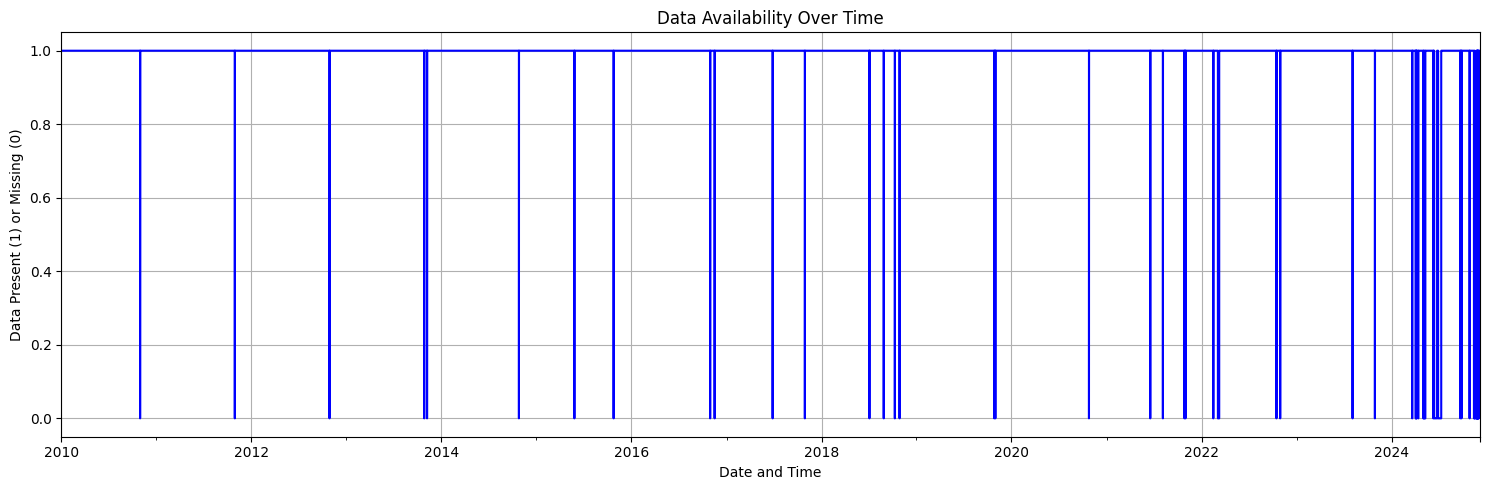

In [ ]:
# Step 1: Create a complete range of hourly timestamps
full_range = pd.date_range(start=df['Date et heure de comptage'].min(), 
                           end=df['Date et heure de comptage'].max(), 
                           freq='h')

# Step 2: Create a DataFrame with the full range and mark present/missing timestamps
full_df = pd.DataFrame({'Date et heure de comptage': full_range})
full_df['Data Present'] = full_df['Date et heure de comptage'].isin(df['Date et heure de comptage']).astype(int)

# Set the datetime column as the index for plotting
full_df.set_index('Date et heure de comptage', inplace=True)

# Step 3: Plot the data availability over time
plt.figure(figsize=(15, 5))
full_df['Data Present'].plot(drawstyle='steps-post', color='blue')
plt.xlabel('Date and Time')
plt.ylabel('Data Present (1) or Missing (0)')
plt.title('Data Availability Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

## Reindex DataFrame to Ensure Hourly Continuity

This cell ensures that the dataset contains a complete range of hourly timestamps, even for missing hours.

### Steps:
1. **Generate a Full Hourly Range:**
   - From the earliest timestamp in the dataset (`Date et heure de comptage`) to the fixed end date (December 31st, 2024).
   - The full range ensures consistency in the time-series data.

2. **Reindex the DataFrame:**
   - Set `Date et heure de comptage` as the index.
   - Align the dataset with the full range of hourly timestamps, inserting rows with missing timestamps.

3. **Handle Missing Values:**
   - Missing values for new rows (timestamps) are left as `NaN` for now.
   - Placeholder values (e.g., `0` or forward fill/backward fill) can be applied based on the modeling needs.

### Key Insights:
- The difference in row counts before and after reindexing indicates the number of missing timestamps filled with `NaN`.
- This step standardizes the time index, which is critical for time-series forecasting models.

In [199]:
print("Number of rows before reindexing:", len(df))

# end_date = df['Date et heure de comptage'].max()
# Set end date to December 31st 2024
end_date = pd.Timestamp('2024-12-31').tz_localize('UTC')

# Step 1: Create a full hourly datetime range
full_range = pd.date_range(start=df['Date et heure de comptage'].min(), 
                           end=end_date, 
                           freq='h')

# Step 2: Reindex the DataFrame
df = df.set_index('Date et heure de comptage')
df = df.reindex(full_range)

# Step 3: Rename the index to match the original column name
df.index.name = 'Date et heure de comptage'

df.reset_index(inplace=True)

print("Number of rows after reindexing:", len(df))

# Step 4: Handle missing values (optional)
# Option 1: Leave NaNs (explicitly missing data)
# Option 2: Fill with a placeholder (e.g., 0)
# df_reindexed.fillna(0, inplace=False)  # Or specify a method like "ffill" or "bfill"

Number of rows before reindexing: 129523
Number of rows after reindexing: 131473


## Add Holiday and Bank Holiday Information

### Purpose:
This cell enriches the dataset with holiday-related information, which can be important predictors for traffic patterns.

### Steps:
1. **Load Holiday Data:**
   - Reads a CSV file containing holiday and bank holiday information.
   - The `date` column in the holiday data is parsed as a datetime object for consistency.

2. **Merge with Traffic Data:**
   - Converts the `Date et heure de comptage` column from the traffic data to a `date` format.
   - Merges the holiday data with the traffic dataset on the `date` column.
   - Columns `vacances_zone_c` (school holidays) and `ferie` (bank holidays) are added to the traffic data.

3. **Handle Missing Values:**
   - Missing values in `vacances_zone_c` and `ferie` are filled with `0`, indicating no holiday.

4. **Clean Temporary Columns:**
   - Drops the temporary `date` column after merging to maintain a clean DataFrame.

### Key Insights:
- Adding holiday and bank holiday information enhances the dataset by including features that impact traffic behavior.
- The enriched dataset now contains additional columns such as:
  - **`vacances_zone_c`**: Indicates if it is a school holiday.
  - **`ferie`**: Indicates if it is a bank holiday.
  - **`nom_vacances` and `nom_jour_ferie`**: Names of the specific holiday (optional but useful for analysis).

In [200]:
# Add the holiday and bank holiday columns

# Load the holidays data
holidays = pd.read_csv("data/holidays_bank_holidays.csv", parse_dates=["date"])

# Ensure the 'date' columns in both DataFrames are of the same type
df['date'] = df["Date et heure de comptage"].dt.date  # Convert to datetime.date
holidays['date'] = holidays['date'].dt.date  # Convert to datetime.date

# Merge the two DataFrames on the "date" column
df = df.merge(holidays, on="date", how="left")

# Fill missing values without using inplace=True
df["vacances_zone_c"] = df["vacances_zone_c"].fillna(0)  # Assuming 0 means not a holiday
df["ferie"] = df["ferie"].fillna(0)  # Assuming 0 means not a bank holiday

# Drop the temporary "date" column if it's no longer needed
df = df.drop(columns=["date"])

# Display the updated DataFrame
df.head()

,Date et heure de comptage,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,vacances_zone_a,vacances_zone_b,vacances_zone_c,nom_vacances,ferie,nom_jour_ferie
0,2010-01-01 00:00:00+00:00,4264.0,AV_Champs_Elysees,2.0,0.0,1,2294.0,Av_Champs_Elysees-Washington,2293.0,Av_Champs_Elysees-Berri,1,NaN,NaN,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier
1,2010-01-01 01:00:00+00:00,4264.0,AV_Champs_Elysees,5.0,0.0,1,2294.0,Av_Champs_Elysees-Washington,2293.0,Av_Champs_Elysees-Berri,1,NaN,NaN,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier
2,2010-01-01 02:00:00+00:00,4264.0,AV_Champs_Elysees,23.0,0.0,1,2294.0,Av_Champs_Elysees-Washington,2293.0,Av_Champs_Elysees-Berri,1,NaN,NaN,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier
3,2010-01-01 03:00:00+00:00,4264.0,AV_Champs_Elysees,1163.0,15.0,2,2294.0,Av_Champs_Elysees-Washington,2293.0,Av_Champs_Elysees-Berri,1,NaN,NaN,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier
4,2010-01-01 04:00:00+00:00,4264.0,AV_Champs_Elysees,1384.0,10.0,1,2294.0,Av_Champs_Elysees-Washington,2293.0,Av_Champs_Elysees-Berri,1,NaN,NaN,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier


## Check for Missing Values in the Dataset

### Purpose:
This cell identifies the extent of missing values in each column of the dataset, which helps in planning the preprocessing and data cleaning steps.

### Key Insights:
- **Critical Columns:** 
  - Columns like `Débit horaire` and `Taux d'occupation` (primary targets for modeling) have some missing values that need to be addressed.
- **Less Critical Columns:** 
  - Columns like `Date debut dispo data` and `Date fin dispo data` have a high number of missing values, and their relevance should be evaluated.
- **Holiday Columns:**
  - Columns such as `vacances_zone_c` and `ferie` are fully populated, ensuring reliable feature information.

### Next Steps:
- Decide how to handle missing values:
  - For target variables like `Débit horaire` and `Taux d'occupation`, filling techniques such as interpolation or forward fill/backward fill may be applied.
  - Drop columns with excessive missing data (e.g., `Date debut dispo data`).
  - For categorical columns (e.g., `Etat trafic`), consider filling with the most frequent value or a placeholder.

In [201]:
# Check for missing values in each column
df.isnull().sum()

Date et heure de comptage         0
Identifiant arc                1951
Libelle                        1951
Débit horaire                  9222
Taux d'occupation              9927
Etat trafic                    1951
Identifiant noeud amont        1951
Libelle noeud amont            1951
Identifiant noeud aval         1951
Libelle noeud aval             1951
Etat arc                       1951
Date debut dispo data        123950
Date fin dispo data          123950
vacances_zone_a                 241
vacances_zone_b                 241
vacances_zone_c                   0
nom_vacances                  77113
ferie                             0
nom_jour_ferie               127537
dtype: int64

## Extract DateTime Features for Model Enrichment

### Purpose:
This cell extracts additional temporal features from the `Date et heure de comptage` column to enhance the dataset for time-series modeling.

### Features Extracted:
1. **Year**: Captures the annual trend or seasonality.
2. **Month**: Helps model monthly patterns (e.g., increased traffic in December).
3. **Day**: Identifies daily variations.
4. **Hour**: Crucial for capturing hourly traffic patterns.
5. **DayOfWeek**: Encodes the day of the week (0 = Monday, 6 = Sunday), which is useful for modeling weekday vs. weekend effects.

### Why These Features Matter:
- **Temporal Features:** Time-based features are critical for capturing periodic behaviors in traffic data.
- **Modeling Utility:** These features can be used directly in machine learning models or for aggregating and analyzing data patterns.

### Next Steps:
- Explore the extracted features to identify trends and validate their utility in modeling.
- Incorporate these features as inputs for the prediction model.

In [202]:
# Extract datetime features from 'Date et heure de comptage'
df['Year'] = df['Date et heure de comptage'].dt.tz_convert("Europe/Paris").dt.year
df['Month'] = df['Date et heure de comptage'].dt.tz_convert("Europe/Paris").dt.month
df['Day'] = df['Date et heure de comptage'].dt.tz_convert("Europe/Paris").dt.day
df['Hour'] = df['Date et heure de comptage'].dt.tz_convert("Europe/Paris").dt.hour
df['DayOfWeek'] = df['Date et heure de comptage'].dt.tz_convert("Europe/Paris").dt.dayofweek
new_features = ['Year', 'Month', 'Day', 'Hour', 'DayOfWeek']

## Statistical Summary of Numerical Columns

### Overview:
This step provides a statistical summary of all numerical columns in the dataset, which is essential for understanding the data's distribution and range.

### Key Metrics:
- **Count:** Number of non-missing values in each column.
- **Mean & Std:** Average and standard deviation, highlighting central tendency and variability.
- **Min & Max:** Extremes of the dataset, useful for identifying outliers.
- **25%, 50%, 75%:** Percentile values (quartiles), showing the spread of the data.

### Insights from the Output:
- **Débit horaire (Hourly Traffic Flow):**
  - Mean traffic flow is ~1185 vehicles/hour, with a wide range from 0 to over 1600 (75th percentile).
- **Taux d'occupation (Occupancy Rate):**
  - Mean occupancy is ~11.8%, with high variability (standard deviation ~9.8%).
- **Temporal Features:**
  - `Year` spans from 2010 to 2024, with uniform distribution across months, days, and hours.
- **Holiday Features:**
  - Binary features like `vacances_zone_c` and `ferie` indicate that ~33% of the data corresponds to holidays or vacations.

### Next Steps:
- Use this information to identify potential outliers or anomalies in critical columns like `Débit horaire` and `Taux d'occupation`.
- Inform feature engineering and data preprocessing strategies.

In [203]:
# Display statistical summaries of numerical columns
df.describe()

,Identifiant arc,Débit horaire,Taux d'occupation,Identifiant noeud amont,Identifiant noeud aval,vacances_zone_a,vacances_zone_b,vacances_zone_c,ferie,Year,Month,Day,Hour,DayOfWeek
count,129522.0,122251.000000,121546.000000,129522.0,129522.0,131232.000000,131232.000000,131473.000000,131473.000000,131473.000000,131473.000000,131473.000000,131473.000000,131473.000000
mean,4264.0,1185.282223,11.789053,2294.0,2293.0,0.337235,0.337418,0.336982,0.029938,2016.999612,6.522647,15.727822,11.499920,3.000510
std,0.0,644.858105,9.836147,0.0,0.0,0.472768,0.472831,0.472680,0.170416,4.320093,3.448308,8.798870,6.922247,2.000333
min,4264.0,0.000000,0.000000,2294.0,2293.0,0.000000,0.000000,0.000000,0.000000,2010.000000,1.000000,1.000000,0.000000,0.000000
25%,4264.0,679.000000,5.376110,2294.0,2293.0,0.000000,0.000000,0.000000,0.000000,2013.000000,4.000000,8.000000,5.000000,1.000000
50%,4264.0,1123.000000,9.566670,2294.0,2293.0,0.000000,0.000000,0.000000,0.000000,2017.000000,7.000000,16.000000,11.000000,3.000000
75%,4264.0,1694.000000,14.591552,2294.0,2293.0,1.000000,1.000000,1.000000,0.000000,2021.000000,10.000000,23.000000,17.000000,5.000000
max,4264.0,6530.000000,99.007780,2294.0,2293.0,1.000000,1.000000,1.000000,1.000000,2024.000000,12.000000,31.000000,23.000000,6.000000


In [204]:
df[3000:].head()

,Date et heure de comptage,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,vacances_zone_a,vacances_zone_b,vacances_zone_c,nom_vacances,ferie,nom_jour_ferie,Year,Month,Day,Hour,DayOfWeek
3000,2010-05-06 00:00:00+00:00,4264.0,AV_Champs_Elysees,820.0,4.0,1,2294.0,Av_Champs_Elysees-Washington,2293.0,Av_Champs_Elysees-Berri,1,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,2010,5,6,2,3
3001,2010-05-06 01:00:00+00:00,4264.0,AV_Champs_Elysees,609.0,3.0,1,2294.0,Av_Champs_Elysees-Washington,2293.0,Av_Champs_Elysees-Berri,1,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,2010,5,6,3,3
3002,2010-05-06 02:00:00+00:00,4264.0,AV_Champs_Elysees,342.0,2.0,1,2294.0,Av_Champs_Elysees-Washington,2293.0,Av_Champs_Elysees-Berri,1,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,2010,5,6,4,3
3003,2010-05-06 03:00:00+00:00,4264.0,AV_Champs_Elysees,332.0,2.0,1,2294.0,Av_Champs_Elysees-Washington,2293.0,Av_Champs_Elysees-Berri,1,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,2010,5,6,5,3
3004,2010-05-06 04:00:00+00:00,4264.0,AV_Champs_Elysees,580.0,3.0,1,2294.0,Av_Champs_Elysees-Washington,2293.0,Av_Champs_Elysees-Berri,1,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,2010,5,6,6,3


## Visualizing Trends in `Débit horaire` Across Temporal Features

### Purpose:
This section visualizes the variations in hourly traffic flow (`Débit horaire`) across key temporal features:
1. **Yearly Trend:** Highlights changes in traffic flow over the years.
2. **Monthly Seasonality:** Displays monthly variations, which may reveal peak and off-peak months.
3. **Daily Patterns:** Examines fluctuations in traffic on different days of the month.
4. **Hourly Patterns:** Shows typical daily traffic cycles.
5. **Weekly Trends:** Explores variations across days of the week (e.g., weekdays vs weekends).

### Observations:
- **Year:** Traffic flow decreases over time, with some fluctuations.
- **Month:** Peak traffic is observed mid-year, with dips in certain months (e.g., August).
- **Day:** Traffic varies across days, showing potential for weekday-weekend effects.
- **Hour:** Clear daily cycle, with peaks during rush hours and drops at night.
- **Day of Week:** Traffic increases during the weekdays and drops sharply on weekends.

### Next Steps:
- Use these visualizations to identify critical patterns and validate their significance for model training.
- Consider encoding these temporal features explicitly in the machine learning pipeline.

/var/folders/_8/vpwl6kq551v_bt6m3llx5n9c0000gn/T/ipykernel_62923/1423280018.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
/var/folders/_8/vpwl6kq551v_bt6m3llx5n9c0000gn/T/ipykernel_62923/1423280018.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
/var/folders/_8/vpwl6kq551v_bt6m3llx5n9c0000gn/T/ipykernel_62923/1423280018.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
/var/folders/_8/vpwl6kq551v_bt6m3llx5n9c0000gn/T/ipy

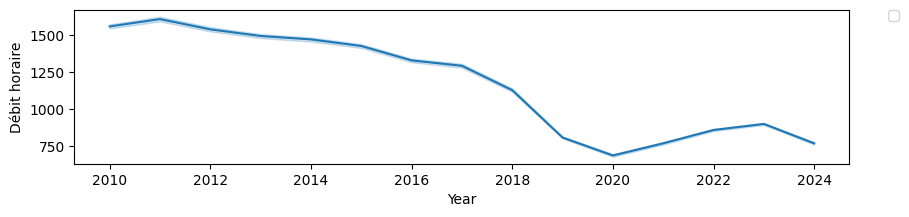

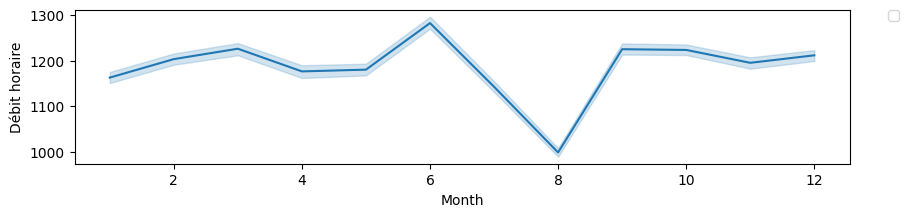

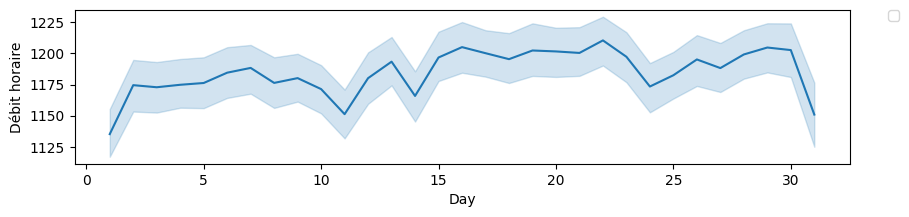

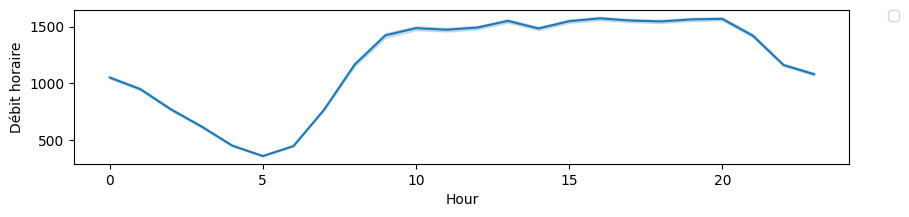

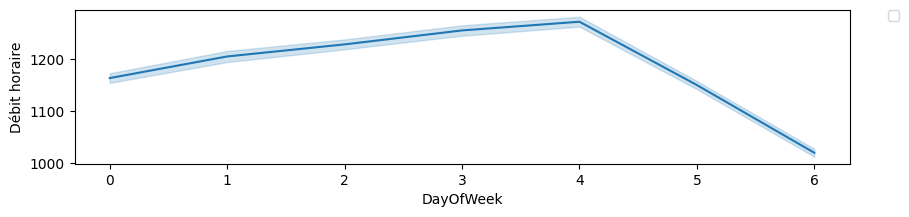

In [205]:
colors = ["#FF5733", "#33FF57", "#5733FF", "#FF33F9"]
for i in new_features:
    plt.figure(figsize=(10,2),facecolor='w')
    ax=sns.lineplot(x=df[i],y="Débit horaire",data=df)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Mean Hourly Traffic by Day of the Week (Side-by-Side Visualization)

### Objective:
This plot provides a detailed view of the average hourly traffic (`Débit horaire`) for each day of the week. By shifting the x-axis for each day, we can compare daily traffic patterns side-by-side.

### Key Features:
1. **Grouping by Day and Hour:**
   - The dataset is grouped by `DayOfWeek` and `Hour` to calculate the mean `Débit horaire` for each combination.
2. **Visual Separation by Day:**
   - The x-axis is adjusted to place each day's data sequentially, making it easier to compare trends.

### Observations:
- **Weekdays (Monday to Friday):**
  - Traffic is high during typical morning (7-10 AM) and evening (5-8 PM) rush hours.
- **Weekends (Saturday and Sunday):**
  - Traffic is more evenly distributed, with lower peaks compared to weekdays.
- **Friday:**
  - Displays a distinct pattern, combining weekday rush hour trends with increasing evening traffic.

### Importance for Modeling:
- Highlights the necessity of incorporating both `DayOfWeek` and `Hour` features into predictive models.
- Demonstrates potential differences in traffic behavior across weekdays and weekends, which can significantly influence predictions.

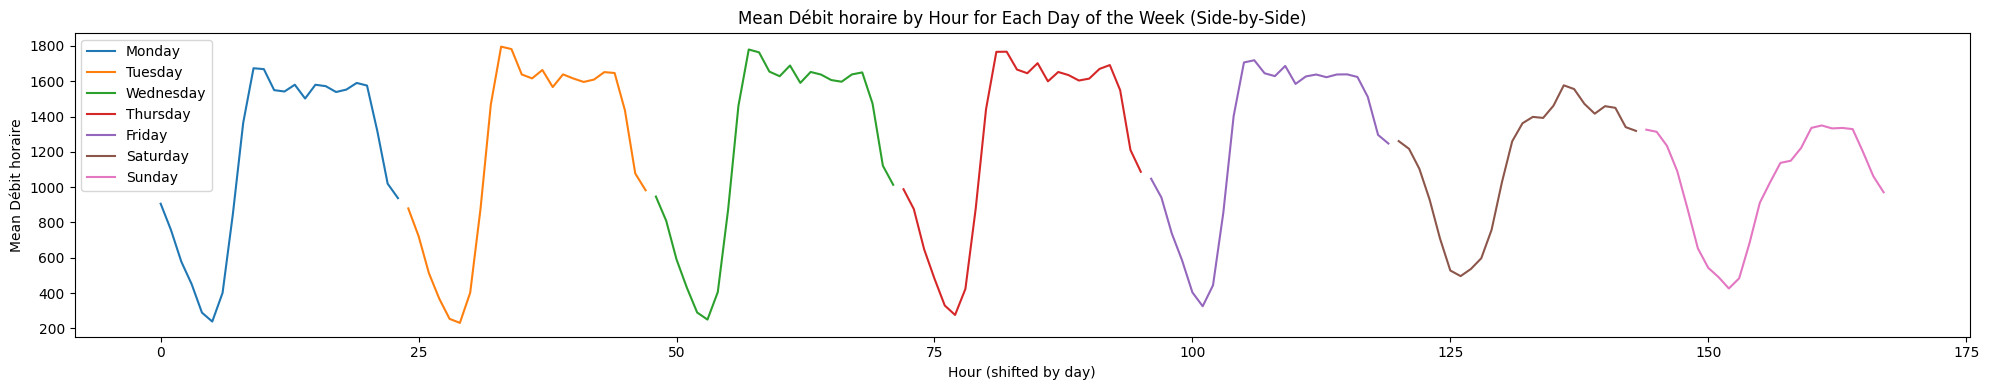

In [206]:
# Group the data by DayOfWeek and Hour, and calculate the mean Débit horaire
mean_values = df.groupby(['DayOfWeek', 'Hour'])['Débit horaire'].mean().reset_index()

# Define day names
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(20,4))

# Plot each day, offsetting the x-values by 24 hours per day
for i, day_name in enumerate(days):
    day_data = mean_values[mean_values['DayOfWeek'] == i]
    # Shift the hours by 24*i to place each day side by side
    shifted_hours = day_data['Hour'] + (i * 24)
    sns.lineplot(x=shifted_hours, y=day_data['Débit horaire'], label=day_name)

plt.xlabel("Hour (shifted by day)")
plt.ylabel("Mean Débit horaire")
plt.title("Mean Débit horaire by Hour for Each Day of the Week (Side-by-Side)")
plt.legend()
plt.tight_layout()
plt.show()

## Distribution Analysis: `Débit horaire` and `Taux d'occupation`

### Objective:
These visualizations explore the distribution of the two primary variables:
1. **`Débit horaire` (Hourly Traffic Flow):** Measures the number of vehicles per hour.
2. **`Taux d'occupation` (Lane Occupancy Rate):** Indicates the percentage of lane usage.

### Key Observations:
1. **`Débit horaire`:**
   - The distribution is slightly **right-skewed**, with most values between 500 and 2000.
   - Peaks around ~1000 suggest typical traffic conditions, while higher values may represent traffic jams or high-demand periods.
2. **`Taux d'occupation`:**
   - Highly **right-skewed**, with the majority of values below 20%.
   - Very few observations exceed 50%, which may represent heavily congested scenarios.

### Insights for Modeling:
- Both distributions exhibit skewness, which might require transformations (e.g., log scale) to normalize for certain machine learning models.
- The observed patterns confirm significant variability in traffic and occupancy, underlining the importance of feature engineering and robust modeling.

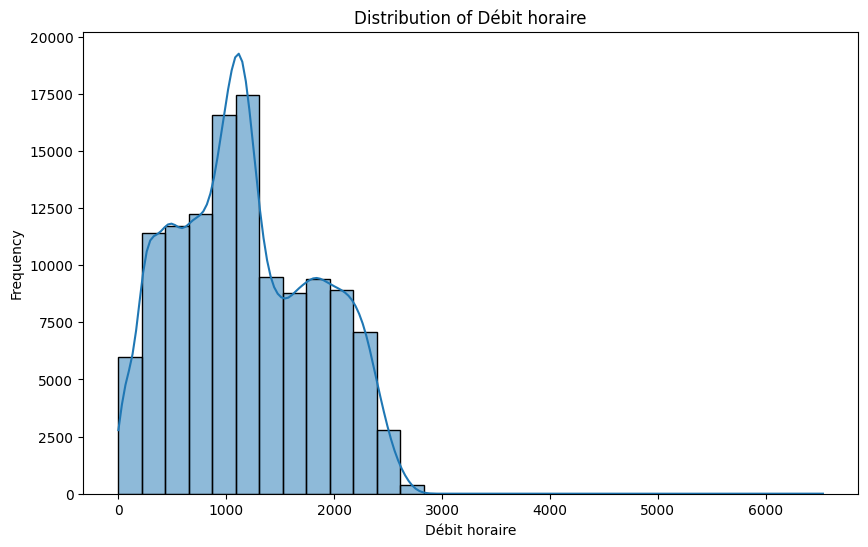

In [207]:
# Visualize the distribution of 'Débit horaire'
plt.figure(figsize=(10, 6))
sns.histplot(df['Débit horaire'], kde=True, bins=30)
plt.title('Distribution of Débit horaire')
plt.xlabel('Débit horaire')
plt.ylabel('Frequency')
plt.show()

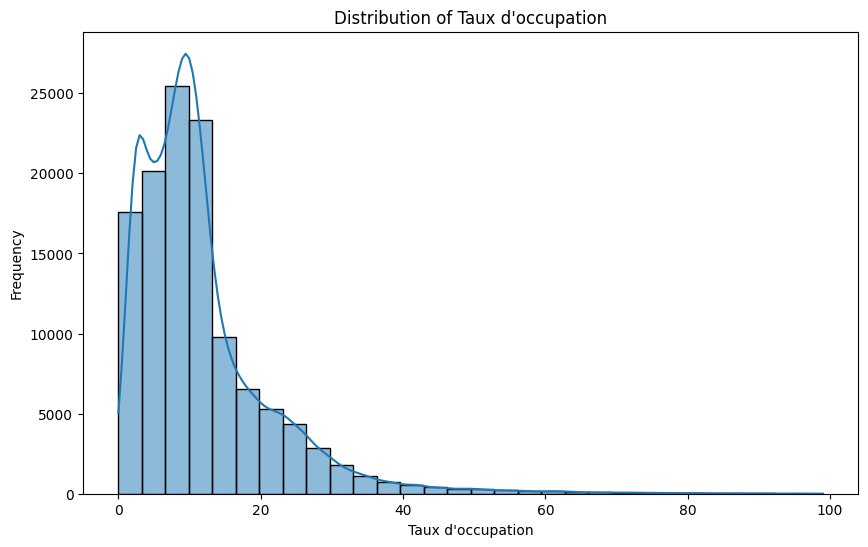

In [208]:
# Visualize the distribution of 'Taux d\'occupation'
plt.figure(figsize=(10, 6))
sns.histplot(df['Taux d\'occupation'], kde=True, bins=30)
plt.title('Distribution of Taux d\'occupation')
plt.xlabel('Taux d\'occupation')
plt.ylabel('Frequency')
plt.show()

## Correlation Matrix of Numerical Features

### Objective:
This heatmap visualizes the correlations between numerical features in the dataset. Correlation values range from -1 to 1:
- **Positive Correlation:** A value closer to 1 indicates that as one feature increases, the other tends to increase.
- **Negative Correlation:** A value closer to -1 indicates an inverse relationship.
- **No Correlation:** A value near 0 implies little to no linear relationship.

### Key Observations:
1. **`Débit horaire` (Hourly Traffic Flow):**
   - Moderately correlated with `Hour` (0.41), reflecting daily traffic patterns.
   - Weak correlation with `Taux d'occupation` (0.26), suggesting these metrics have distinct behaviors.
2. **`Taux d'occupation` (Lane Occupancy Rate):**
   - Similar weak correlation with `Hour` (0.31).
3. **Holidays (`vacances_zone_c`, `ferie`):**
   - Weak or no correlation with traffic metrics, indicating that holidays might not directly impact traffic in this dataset.
4. **Temporal Features:**
   - `Year` shows a negative correlation with `Débit horaire` (-0.47), possibly reflecting a decline in traffic over time.

### Importance for Analysis:
- Features like `Hour` and `Year` appear to have the strongest relationships with traffic flow.
- Weak correlations suggest that additional derived features or non-linear relationships may be necessary to improve predictions.
- The matrix aids in identifying redundant features (e.g., `vacances_zone_a`, `vacances_zone_b`, `vacances_zone_c` are highly correlated) for potential dimensionality reduction.

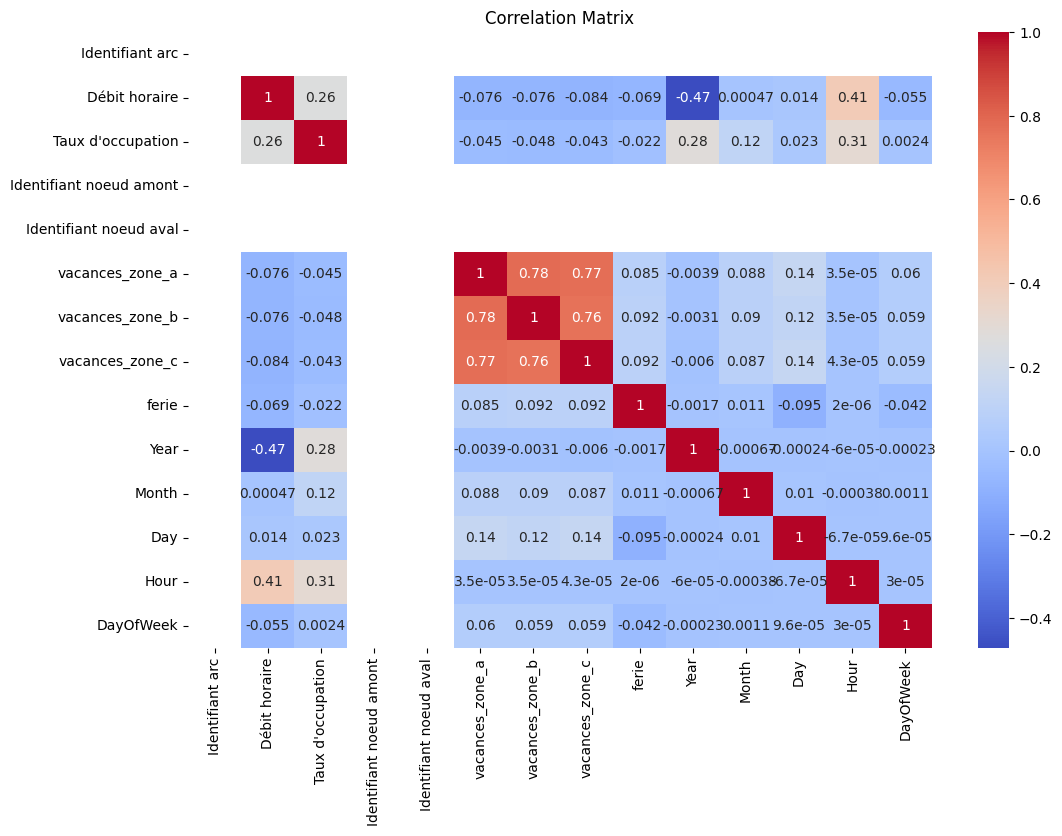

In [209]:
# Correlation matrix of numerical features
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Hourly Trends in Traffic Flow and Lane Occupancy

### Purpose:
These plots highlight the hourly patterns of:
1. **`Débit horaire` (Hourly Traffic Flow):** The average number of vehicles per hour.
2. **`Taux d'occupation` (Lane Occupancy Rate):** The average percentage of lane usage per hour.

### Observations:
1. **`Débit horaire`:**
   - Traffic starts increasing early in the morning, peaking around 7-10 AM (morning rush hour).
   - A second peak is observed in the evening around 4-7 PM (evening rush hour).
   - Traffic flow decreases significantly during the night (12-5 AM).

2. **`Taux d'occupation`:**
   - The occupancy rate follows a similar trend, with peaks during rush hours.
   - Lower occupancy during off-peak hours (night and early morning) suggests reduced congestion.

### Insights for Modeling:
- These patterns confirm the importance of the `Hour` feature in predictive models.
- Rush hour effects and cyclical trends can be modeled explicitly using time-series techniques or engineered features.

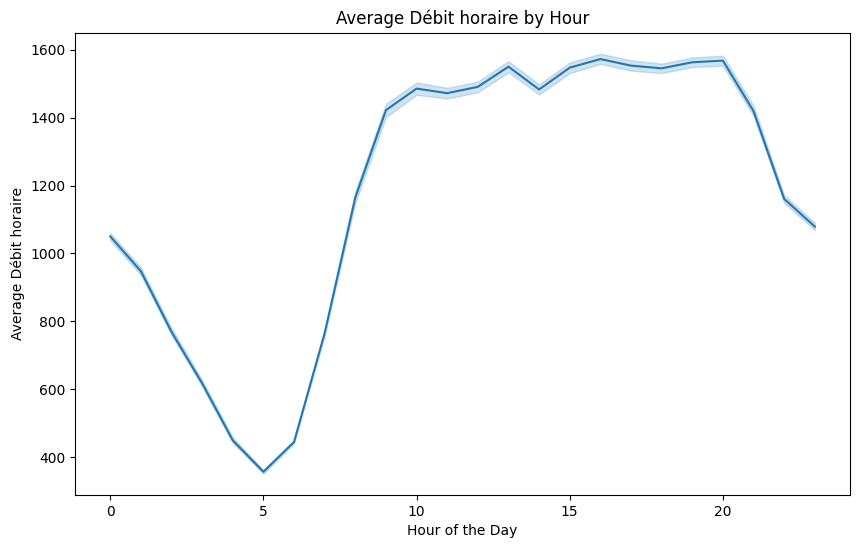

In [210]:
# Visualize 'Débit horaire' over different hours of the day
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Hour', y='Débit horaire', estimator='mean')
plt.title('Average Débit horaire by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Débit horaire')
plt.show()

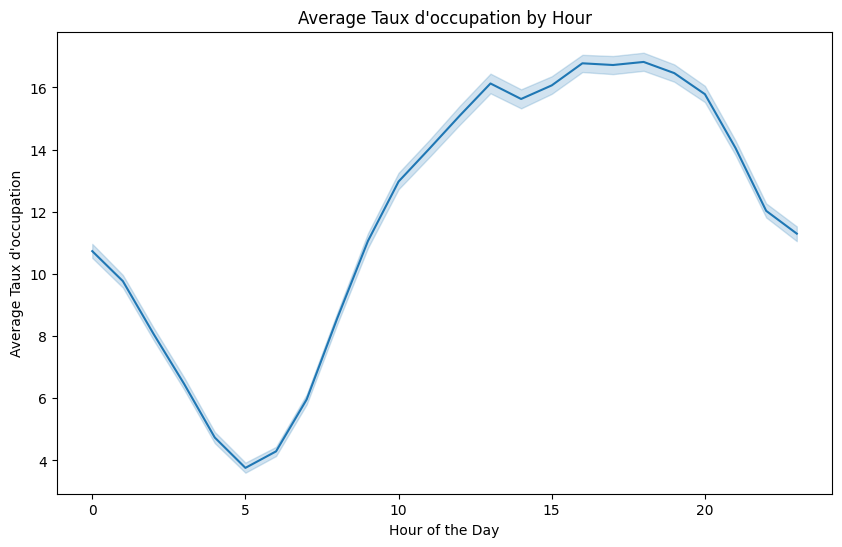

In [211]:
# Visualize 'Taux d\'occupation' over different hours of the day
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Hour', y='Taux d\'occupation', estimator='mean')
plt.title('Average Taux d\'occupation by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Taux d\'occupation')
plt.show()

## Analysis of `Débit horaire` and `Taux d'occupation` by `Etat trafic`

### Objective:
These bar plots illustrate how traffic flow (`Débit horaire`) and lane occupancy (`Taux d'occupation`) vary across different traffic states (`Etat trafic`).

### Observations:
1. **`Débit horaire`:**
   - Traffic flow is highest during certain states (e.g., `2` and `3`), likely representing free-flowing or moderately congested traffic.
   - Lower flow occurs in `Bloqué` (Blocked) or `Inconnu` (Unknown) states, suggesting significant congestion or data anomalies.

2. **`Taux d'occupation`:**
   - Lane occupancy peaks in states labeled as `4` and `Bloqué`, which likely correspond to heavy congestion.
   - Low occupancy during free-flowing states (e.g., `Fluide`) indicates smoother traffic.

### Note:
- **Data Issue:** The `Etat trafic` categories have not been correctly renamed by the loader script, making interpretation harder. Resolving this will provide clearer insights into traffic states.

### Next Steps:
1. Fix the categorical renaming issue for `Etat trafic`.
2. Re-analyze to confirm these patterns.
3. Consider the impact of these states in predictive models.

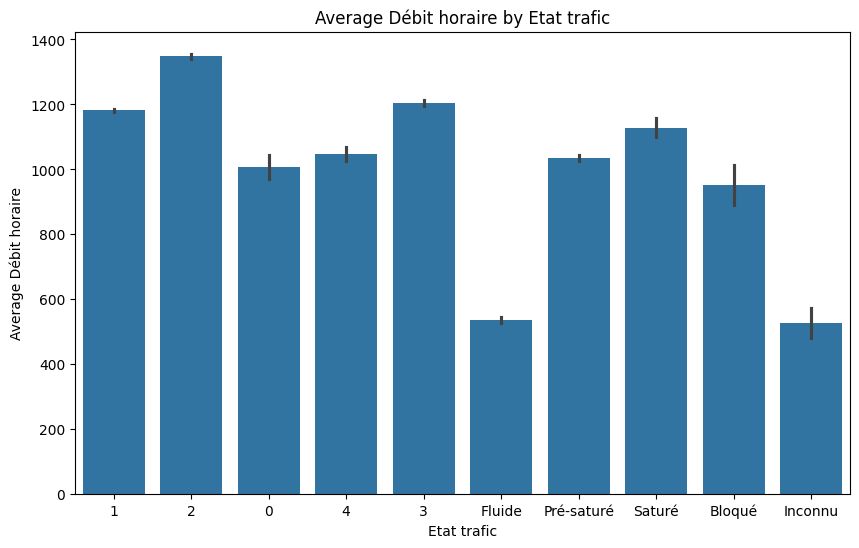

In [212]:
# Analyze 'Débit horaire' by 'Etat trafic'
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Etat trafic', y='Débit horaire')
plt.title('Average Débit horaire by Etat trafic')
plt.xlabel('Etat trafic')
plt.ylabel('Average Débit horaire')
plt.show()

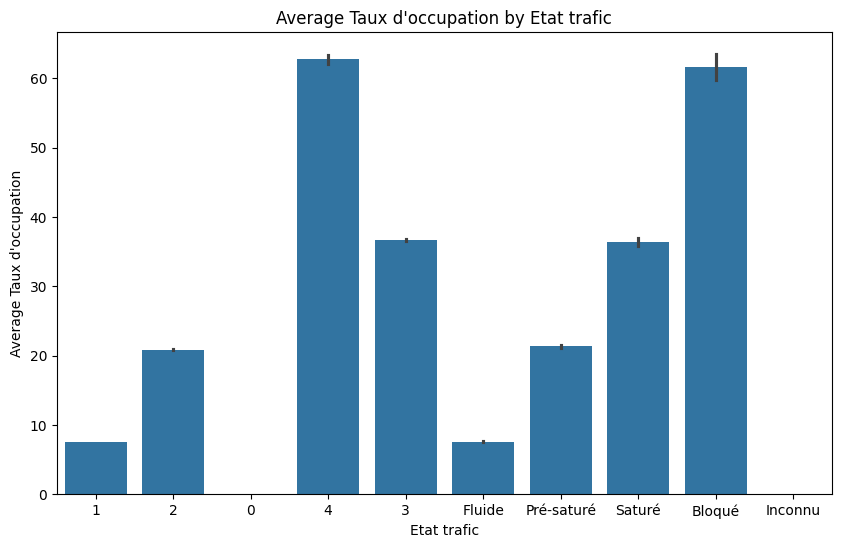

In [213]:
# Analyze 'Taux d\'occupation' by 'Etat trafic'
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Etat trafic', y='Taux d\'occupation')
plt.title('Average Taux d\'occupation by Etat trafic')
plt.xlabel('Etat trafic')
plt.ylabel('Average Taux d\'occupation')
plt.show()

## Predictions Using Chronos and AutoGluon

### Objective:
This section focuses on leveraging **Chronos** and **AutoGluon** for time-series forecasting of traffic metrics (`Débit horaire` and `Taux d'occupation`). The goals include:
1. Predicting future traffic flow and lane occupancy over a defined prediction horizon.
2. Evaluating model performance using metrics like RMSE and WQL.
3. Utilizing known covariates (e.g., holidays, time of day) to enhance prediction accuracy.

### Key Steps:
1. **Data Preparation:**
   - Ensure data consistency by handling missing timestamps and filling missing values.
   - Add relevant features like holidays, weekdays, and other temporal covariates.

2. **Model Training:**
   - Train AutoGluon's `TimeSeriesPredictor` using Chronos models.
   - Experiment with zero-shot predictions and fine-tuning strategies.

3. **Prediction Evaluation:**
   - Generate predictions for both training and testing periods.
   - Evaluate model performance using various metrics (e.g., RMSE).
   - Visualize actual vs predicted traffic metrics to understand model performance.

4. **Future Steps:**
   - Analyze prediction errors and patterns for further optimization.
   - Experiment with different hyperparameters and Chronos models to improve results.

### Importance:
Accurate traffic predictions enable:
- Improved planning for city logistics and resource allocation

## Dropping Irrelevant Columns

### Objective:
To streamline the dataset and focus on features relevant for prediction, we remove constant or redundant columns that do not provide additional information for the model. This helps:
- Reduce computational overhead.
- Avoid introducing unnecessary noise into the predictive models.

### Explanation:
1. Columns like `Identifiant arc`, `Libelle`, and node identifiers are constant or categorical identifiers irrelevant for time-series forecasting.
2. `Date debut dispo data` and `Date fin dispo data` are mostly missing and do not contribute to the predictive task.

### Action:
These columns will be dropped to create a clean and optimized dataset for modeling.

In [214]:
df.drop(columns=['Libelle', 'Identifiant arc', 'Identifiant noeud amont', 'Libelle noeud amont',
                 'Identifiant noeud aval', 'Libelle noeud aval', 'Date debut dispo data', 'Date fin dispo data'], inplace=True)
df.head()

,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Etat arc,vacances_zone_a,vacances_zone_b,vacances_zone_c,nom_vacances,ferie,nom_jour_ferie,Year,Month,Day,Hour,DayOfWeek
0,2010-01-01 00:00:00+00:00,2.0,0.0,1,1,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier,2010,1,1,1,4
1,2010-01-01 01:00:00+00:00,5.0,0.0,1,1,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier,2010,1,1,2,4
2,2010-01-01 02:00:00+00:00,23.0,0.0,1,1,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier,2010,1,1,3,4
3,2010-01-01 03:00:00+00:00,1163.0,15.0,2,1,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier,2010,1,1,4,4
4,2010-01-01 04:00:00+00:00,1384.0,10.0,1,1,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier,2010,1,1,5,4


In [215]:
# Specify the columns to one-hot encode
# columns_to_encode = ['Etat trafic', 'Etat arc', 'nom_vacances', 'nom_jour_ferie', 'DayOfWeek', 'Month']
# Apply one-hot encoding to the specified columns
# df = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode)

## Preparing Data for Time Series Modeling

### Objective:
To format the dataset into a structure compatible with **AutoGluon's TimeSeriesPredictor**, we need to:
1. Add necessary columns for time-series modeling.
2. Set up a unique identifier (`item_id`) for the time series.
3. Rename columns for standardization.

### Key Steps:
1. **Add `item_id`:** 
   - This column uniquely identifies the time series. Since we are working with one series per street, we use a constant identifier (`series_<street>`).

2. **Rename Columns:**
   - Convert `Date et heure de comptage` to `timestamp` to match AutoGluon requirements.
   - Rename the target column (`Débit horaire`) to `target`.

3. **Time Conversion:**
   - Ensure the `timestamp` column is timezone-naive (necessary for AutoGluon) while retaining the original data.

### Importance:
These steps ensure compatibility with the **TimeSeriesPredictor** and allow efficient training and prediction on the data.

In [216]:
# Create a TimeSeriesDataFrame
# df["timestamp"] = df["Date et heure de comptage"]
# df.set_index('Date et heure de comptage', inplace=True)

# Add the required 'item_id' column (since this is a single time series, we use a constant ID)
df['item_id'] = 'series_' + street

df["Date et heure de comptage"] = df["Date et heure de comptage"]

# Rename "Date et heure de comptage" to "timestamp"

display(df.head())

df["timestamp"] = df["Date et heure de comptage"].dt.tz_localize(None)

display(df.head())

# Rename "Débit horaire" to "target"

df["target"] = df[target_variable]
# df["target"] = df["Taux d'occupation"]

,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Etat arc,vacances_zone_a,vacances_zone_b,vacances_zone_c,nom_vacances,ferie,nom_jour_ferie,Year,Month,Day,Hour,DayOfWeek,item_id
0,2010-01-01 00:00:00+00:00,2.0,0.0,1,1,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier,2010,1,1,1,4,series_washington
1,2010-01-01 01:00:00+00:00,5.0,0.0,1,1,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier,2010,1,1,2,4,series_washington
2,2010-01-01 02:00:00+00:00,23.0,0.0,1,1,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier,2010,1,1,3,4,series_washington
3,2010-01-01 03:00:00+00:00,1163.0,15.0,2,1,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier,2010,1,1,4,4,series_washington
4,2010-01-01 04:00:00+00:00,1384.0,10.0,1,1,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier,2010,1,1,5,4,series_washington


,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Etat arc,vacances_zone_a,vacances_zone_b,vacances_zone_c,nom_vacances,ferie,nom_jour_ferie,Year,Month,Day,Hour,DayOfWeek,item_id,timestamp
0,2010-01-01 00:00:00+00:00,2.0,0.0,1,1,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier,2010,1,1,1,4,series_washington,2010-01-01 00:00:00
1,2010-01-01 01:00:00+00:00,5.0,0.0,1,1,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier,2010,1,1,2,4,series_washington,2010-01-01 01:00:00
2,2010-01-01 02:00:00+00:00,23.0,0.0,1,1,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier,2010,1,1,3,4,series_washington,2010-01-01 02:00:00
3,2010-01-01 03:00:00+00:00,1163.0,15.0,2,1,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier,2010,1,1,4,4,series_washington,2010-01-01 03:00:00
4,2010-01-01 04:00:00+00:00,1384.0,10.0,1,1,1.0,1.0,1.0,Vacances de Noël,1.0,1er janvier,2010,1,1,5,4,series_washington,2010-01-01 04:00:00


In [217]:
ts_df = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column='item_id',
)
ts_df.infer_frequency()

'h'

## Visualizing Recent Data and Missing Values

### Objective:
To evaluate the completeness of recent data and identify any missing values or inconsistencies in the target variable (`Débit horaire` or `Taux d'occupation`) over a specified timeframe.

### Key Steps:
1. **Timeframe Definition:**
   - Focus on data from November 1, 2024, to December 30, 2024, to capture recent trends and ensure data quality.

2. **Visualization:**
   - Plot the target variable for the defined period.
   - Use individual lines for each `item_id` (if applicable) to highlight missing sections or irregularities.

3. **Expected Outcome:**
   - Clear visualization of the target variable over time.
   - Identification of any gaps or anomalies in the data that may need attention before modeling.

### Importance:
Analyzing recent data completeness ensures robust model performance and reliable future predictions.

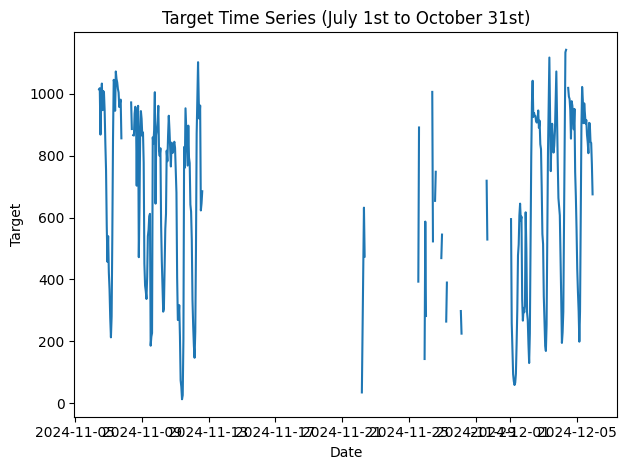

<Figure size 1000x600 with 0 Axes>

In [218]:
import matplotlib.pyplot as plt
import pandas as pd

# Define start and end times as pd.Timestamp
start_date = pd.Timestamp("2024-11-01")
end_date = pd.Timestamp("2024-12-30")

# Filter data between start_date and end_date
filtered_ts_df = ts_df.slice_by_time(start_time=start_date, end_time=end_date)

# Plot the 'target' column
for item_id in filtered_ts_df.item_ids:
    group = filtered_ts_df.loc[item_id]
    plt.plot(group.index, group['target'], label=f"Item {item_id}")

plt.xlabel("Date")
plt.ylabel("Target")
plt.title("Target Time Series (July 1st to October 31st)")
# plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Legend outside the plot
plt.tight_layout()
plt.figure(figsize=(10, 6))
plt.show()

## Splitting Data into Training and Testing Sets

### Objective:
To prepare the data for model training and evaluation by dividing it into a training set and a test set based on a specific cutoff date.

### Key Steps:
1. **Define Cutoff Date:**
   - Set the cutoff date to October 1, 2024. Data before this date will be used for training, and data within the following 10 days will form the test set.
   - The goal is to ensure a realistic evaluation of the model's performance on unseen data.

2. **Prediction Horizon:**
   - Define the prediction length to be 5 days (120 hours). This determines the forecast duration for the model.

3. **Data Splitting:**
   - Use the cutoff date to divide the `TimeSeriesDataFrame` into:
     - `train_data`: Data up to and including the cutoff date.
     - `test_data`: Data from the cutoff date until the specified evaluation period (10 days).

### Importance:
This step ensures that the model is evaluated on a realistic and future-based timeframe, mimicking how predictions will be made in production.

In [219]:
# Define the cutoff point for the test set
cutoff_date = df["timestamp"].max() - pd.DateOffset(months=2)
# Set cutoff to 25 October 2024
cutoff_date = pd.Timestamp("2024-10-01")
print(f"Test set cutoff date: {cutoff_date}")

# Define the prediction length (e.g., 24 hours)
prediction_length = 24 * 5

# Split the data
train_data = ts_df.loc[ts_df.index.get_level_values("timestamp") <= cutoff_date]
test_data = ts_df.loc[(ts_df.index.get_level_values("timestamp") > cutoff_date) & (ts_df.index.get_level_values("timestamp") <= cutoff_date + pd.DateOffset(days=10))]

# train_data = ts_df.slice_by_time(pd.Timestamp(0), cutoff_date)
# test_data = ts_df.slice_by_time(cutoff_date, pd.Timestamp("2024-12-31"))

# cutoff_index = ts_df.loc[ts_df.index.get_level_values("timestamp") <= cutoff_date].shape[0]
# train_data, test_data = ts_df.train_test_split(end_index=cutoff_index, prediction_length=prediction_length)

Test set cutoff date: 2024-10-01 00:00:00


## Training the Time Series Model with Chronos and AutoGluon

### Objective:
To train a **time series prediction model** using AutoGluon's Chronos module. The model aims to forecast traffic metrics (`target`) over a defined horizon (120 hours or 5 days).

### Steps:
1. **Defining Known Covariates:**
   - The following temporal and contextual features are used as covariates to improve prediction accuracy:
     - `Year`, `Month`, `Day`, `Hour`, `DayOfWeek`
     - `vacances_zone_c`, `ferie` (holidays and bank holidays)

2. **Initializing the Predictor:**
   - The `TimeSeriesPredictor` is set up with the following key parameters:
     - `prediction_length`: The forecast horizon is set to 120 hours (5 days).
     - `freq`: Hourly frequency (`'h'`).
     - `verbosity`: Logs are set to detailed (`3`).
     - `known_covariates_names`: List of known covariates to include in the model.

3. **Training Configuration:**
   - The Chronos model `amazon/chronos-bolt-mini` is utilized.
   - The model is trained in a zero-shot mode for quick predictions without fine-tuning.

4. **Training Results:**
   - Model training is completed with a validation score of `-0.1006` (WQL metric).
   - AutoGluon identifies and excludes non-numeric or non-informative columns (`Date et heure de comptage`, `Etat arc`, etc.).
   - The training time is efficient, with a runtime of `0.80 s`.

### Importance:
By using Chronos and leveraging known covariates, the model can generate more accurate predictions, enabling better traffic management and decision-making.

In [ ]:
from autogluon.timeseries import TimeSeriesPredictor

# Specify known covariates
known_covariates_names = ["Year", "Month", "Day", "Hour", "DayOfWeek", "vacances_zone_c", "ferie"]

# Initialize the predictor
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    verbosity=3,
    freq='h',
    known_covariates_names=known_covariates_names,
    # eval_metric="RMSE"
)

predictor.fit(
    train_data,
    # presets='chronos_mini',
    hyperparameters={
        # "Chronos": {
        #     "use_mps": True,
        #     "model_path": "amazon/chronos-bolt-tiny",
        #     "fine_tune": False
        # }
        "Chronos": [
            {"model_path": "amazon/chronos-bolt-mini", "ag_args": {"name_suffix": "ZeroShot"}},
            # {"model_path": "amazon/chronos-bolt-tiny", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    }
)

Beginning AutoGluon training...
AutoGluon will save models to '/Users/louisgauthier/Documents/GitHub/louisgthier/paris-traffic-prediction/AutogluonModels/ag-20241206_160335'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.1.0: Thu Oct 10 21:03:15 PDT 2024; root:xnu-11215.41.3~2/RELEASE_ARM64_T6000
CPU Count:          10
GPU Count:          0
Memory Avail:       42.15 GB / 64.00 GB (65.9%)
Disk Space Avail:   3128.71 GB / 3721.87 GB (84.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'amazon/chronos-bolt-mini'}]},
 'known_covariates_names': ['Year',
                            'Month',
                            'Day',
                            'Hour',
                   

## Generating Predictions with Chronos/AutoGluon

### Objective:
This step focuses on generating **time-series predictions** for the `target` variable using the trained Chronos model. Predictions utilize known covariates to enhance accuracy.

### Steps:
1. **Setting the Forecast Horizon:**
   - The `get_forecast_horizon_index_ts_dataframe` function creates an index representing the forecast horizon based on the training data and the prediction length (120 hours in this case).

2. **Extracting Known Covariates:**
   - Known covariates (`Year`, `Month`, `Day`, `Hour`, `DayOfWeek`, `vacances_zone_c`, `ferie`) are extracted from the test dataset for the forecast horizon.
   - These covariates are used by the model to improve predictions.

3. **Generating Predictions:**
   - The `predictor.predict` method is used to generate predictions based on the training data and the known covariates for the forecast horizon.
   - Predictions are stored in the `predictions` variable and include probabilistic outputs such as mean and quantile forecasts.

### Importance:
By incorporating covariates, the predictions become more context-aware, potentially leading to higher accuracy and reliability for traffic forecasting.

In [221]:
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe

# Generate predictions
# Without covariates
# predictions = predictor.predict(train_data)

# With covariates
future_index = get_forecast_horizon_index_ts_dataframe(train_data, prediction_length=prediction_length)
future_timestamps = future_index.get_level_values("timestamp")
known_covariates = test_data[known_covariates_names]  # Known covariates from test data
predictions = predictor.predict(train_data, known_covariates=known_covariates)


Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[amazon__chronos-bolt-mini]


In [222]:
predictions

mean         0.1         0.2  \
item_id           timestamp                                                 
series_washington 2024-10-01 01:00:00  504.075928  416.131470  449.069092   
                  2024-10-01 02:00:00  379.304138  299.308716  330.593933   
                  2024-10-01 03:00:00  303.066559  226.890808  257.670013   
                  2024-10-01 04:00:00  354.694763  264.652679  300.275146   
                  2024-10-01 05:00:00  617.093811  467.385284  528.844360   
...                                           ...         ...         ...   
                  2024-10-05 20:00:00  927.711060  718.688538  800.074951   
                  2024-10-05 21:00:00  962.269287  740.391357  826.158081   
                  2024-10-05 22:00:00  993.578430  750.490234  841.806335   
                  2024-10-05 23:00:00  964.580017  710.233643  805.706360   
                  2024-10-06 00:00:00  879.477600  629.358948  721.986267   

                                              0.3         0.4         0.5  \
item_id           timestamp                                                 
series_washington 2024-10-01 01:00:00  469.651978  488.347473  504.075928   
                  2024-10-01 02:00:00  350.644775  365.112793  379.304138   
                  2024-10-01 03:00:00  276.685883  290.100769  303.066559   
                  2024-10-01 04:00:00  321.722473  338.349640  354.694763   
                  2024-10-01 05:00:00  565.680969  593.644348  617.093811   
...                                           ...         ...         ...   
                  2024-10-05 20:00:00  851.597290  892.349670  927.711060   
                  2024-10-05 21:00:00  881.500977  923.087891  962.269287   
                  2024-10-05 22:00:00  902.082642  950.150635  993.578430   
                  2024-10-05 23:00:00  867.637939  918.409424  964.580017   
                  2024-10-06 00:00:00  783.458435  832.812500  879.477600   

                                               0.6          0.7          0.8  \
item_id           timestamp                                                    
series_washington 2024-10-01 01:00:00   520.538696   537.354126   560.548584   
                  2024-10-01 02:00:00   393.487793   409.772308   430.580078   
                  2024-10-01 03:00:00   317.021057   332.951782   353.811737   
                  2024-10-01 04:00:00   370.297241   389.591370   413.231689   
                  2024-10-01 05:00:00   640.581299   665.787354   696.807373   
...                                            ...          ...          ...   
                  2024-10-05 20:00:00   964.190063  1001.062012  1046.869995   
                  2024-10-05 21:00:00  1000.477051  1042.074829  1089.996826   
                  2024-10-05 22:00:00  1035.843750  1079.813965  1133.084229   
                  2024-10-05 23:00:00  1007.520569  1053.482666  1106.644531   
                  2024-10-06 00:00:00   922.620911   967.515991  1022.911865   

                                               0.9  
item_id           timestamp                         
series_washington 2024-10-01 01:00:00   595.384338  
                  2024-10-01 02:00:00   464.367310  
                  2024-10-01 03:00:00   389.357605  
                  2024-10-01 04:00:00   453.479431  
                  2024-10-01 05:00:00   745.157837  
...                                            ...  
                  2024-10-05 20:00:00  1110.937866  
                  2024-10-05 21:00:00  1158.800659  
                  2024-10-05 22:00:00  1205.332886  
                  2024-10-05 23:00:00  1187.535645  
                  2024-10-06 00:00:00  1102.137939  

[120 rows x 10 columns]

## Evaluating the Time-Series Predictor

### Objective:
This section evaluates the performance of the trained Chronos model using test data and key metrics such as Weighted Quantile Loss (WQL) and Root Mean Square Error (RMSE).

### Steps:
1. **Preparing the Evaluation Dataset:**
   - The evaluation dataset (`eval_data`) combines:
     - The original training data.
     - The first `prediction_length` rows (e.g., 120 hours) of the test data for evaluation.

2. **Running the Evaluation:**
   - The `predictor.evaluate` method computes the model's performance on the evaluation dataset using:
     - **WQL**: A weighted quantile loss that considers probabilistic predictions.
     - **RMSE**: A standard metric that measures the average prediction error in terms of square differences.

3. **Output Metrics:**
   - **WQL**: -0.0907
   - **RMSE**: -129.69

### Importance:
These metrics provide insight into the model's accuracy and robustness. A low WQL and RMSE indicate that the predictions closely align with actual values, making the model reliable for practical traffic forecasting tasks.

In [223]:
# Prepare the evaluation dataset
# Combine train_data and the first prediction_length rows of test_data
eval_data = TimeSeriesDataFrame(pd.concat(
    [
        train_data,
        test_data.groupby("item_id").head(prediction_length)  # First prediction_length rows of test_data
    ]
))

# Evaluate the predictor
performance = predictor.evaluate(eval_data, metrics=["WQL", "RMSE"])

# Print the performance metrics
print("Evaluation Performance Metrics:")
print(performance)

Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[amazon__chronos-bolt-mini]


Evaluation Performance Metrics:
{'WQL': -0.09068130252624482, 'RMSE': -129.68737330347145}


In [224]:
print(cutoff_date)

2024-10-01 00:00:00


## Predictions vs. Actual Values

### Objective:
This visualization compares the **actual values** of the traffic metric (`target`) with the **predicted values** generated by the Chronos model. The purpose is to assess how closely the model's predictions align with observed data over time.

### Key Features:
1. **Actual Values:**
   - Represented by a solid blue line.
   - Reflects the real observed data during the test period.

2. **Predicted Values:**
   - Represented by a dashed orange line.
   - Shows the forecast generated by the trained model for the same time period.

3. **Key Insights:**
   - Overlapping areas between the two lines indicate accurate predictions.
   - Discrepancies highlight areas where the model's performance can be improved.

### Importance:
This plot provides a clear visual evaluation of the model's accuracy and helps identify patterns, anomalies, or trends in the forecasting results. Such insights are crucial for refining the model and optimizing its performance for real-world applications.

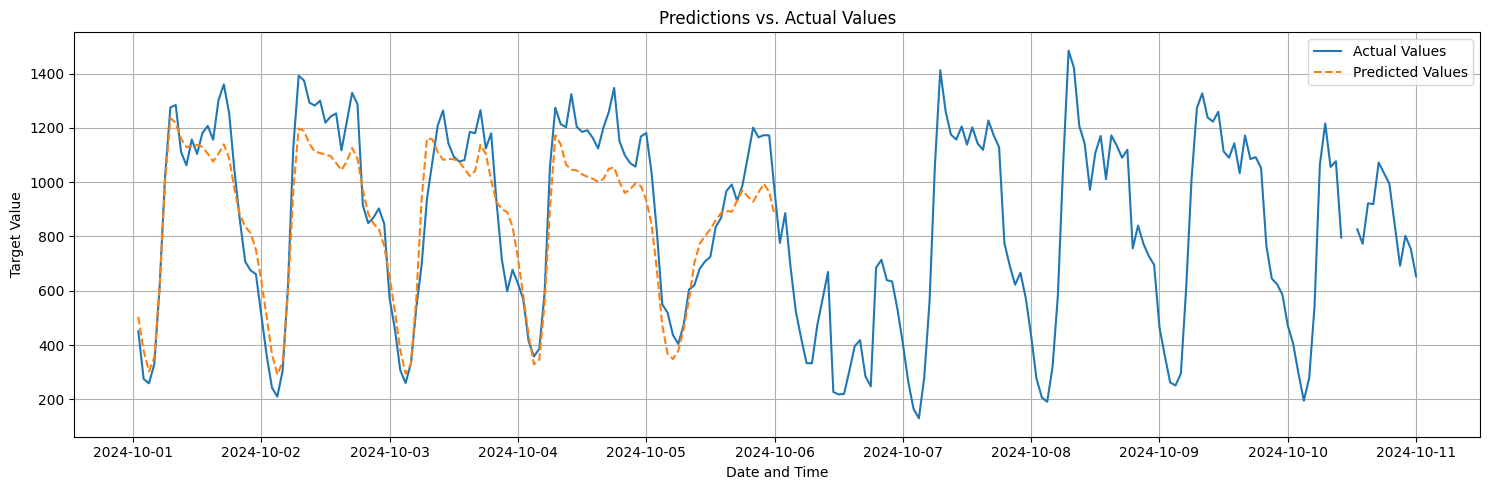

In [225]:
import matplotlib.pyplot as plt

# Ensure predictions and test data have the same structure
# Assuming 'target' is the column in test_data and predictions

# Plot predictions vs. actual values
plt.figure(figsize=(15, 5))

# Plot actual values
plt.plot(test_data.index.get_level_values('timestamp'),
         test_data['target'],
         label='Actual Values',
         linestyle='-')

# Plot predicted values
plt.plot(predictions.index.get_level_values('timestamp'),
         predictions['mean'],
         label='Predicted Values',
         linestyle='--')

# Customize the plot
plt.xlabel('Date and Time')
plt.ylabel('Target Value')
plt.title('Predictions vs. Actual Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

RMSE (Next 5 days after train): 129.68737330347145


Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[amazon__chronos-bolt-mini]
Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[amazon__chronos-bolt-mini]


RMSE after adding 24 hours of test data: 177.9505860602712


Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[amazon__chronos-bolt-mini]


RMSE after adding 48 hours of test data: 196.08319069958208


Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[amazon__chronos-bolt-mini]


RMSE after adding 72 hours of test data: 187.72266443002036


Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[amazon__chronos-bolt-mini]
Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[amazon__chronos-bolt-mini]


RMSE after adding 96 hours of test data: 185.95083478616357
Average RMSE: 186.9268189940093


Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[amazon__chronos-bolt-mini]
Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[amazon__chronos-bolt-mini]


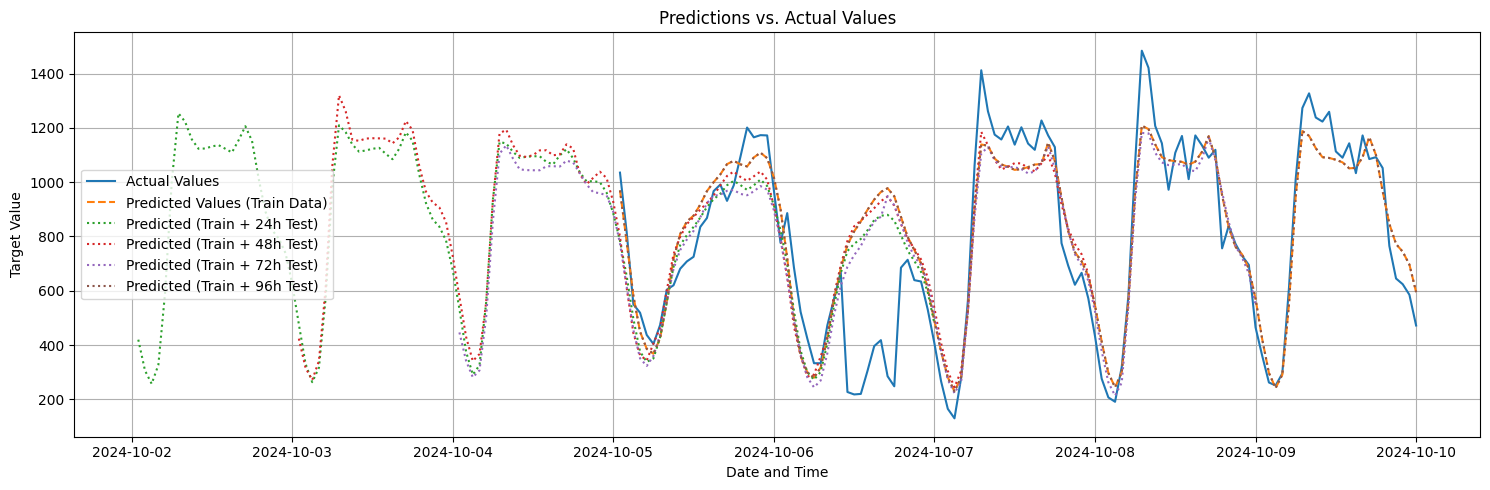

In [226]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Align the MultiIndex between predictions and test data
common_index = predictions.index.intersection(test_data.index)

# Extract aligned actual values and predictions
aligned_actuals = test_data.loc[common_index, "target"]
aligned_predictions = predictions.loc[common_index, "mean"]

# Drop NaN values
valid_mask = ~aligned_actuals.isna() & ~aligned_predictions.isna()
aligned_actuals = aligned_actuals[valid_mask]
aligned_predictions = aligned_predictions[valid_mask]

# Ensure indices are aligned for plotting
aligned_actuals = aligned_actuals.sort_index()
aligned_predictions = aligned_predictions.sort_index()

# Calculate RMSE for train_data predictions
rmse_train = np.sqrt(mean_squared_error(aligned_actuals, aligned_predictions))
print(f"RMSE (Next 5 days after train): {rmse_train}")

# Evaluate RMSE with extended train_data + partial test_data
durations = [24, 48, 72, 96]  # Example durations in hours
rmse_list = []

for duration in durations:
    # Extend train_data with the first 'duration' hours of test_data
    extended_train_data = pd.concat([
        train_data,
        test_data.iloc[:duration]
    ])
    
    # Generate predictions
    predictions_extended = predictor.predict(extended_train_data, known_covariates=known_covariates)
    
    # Align predictions and actual values
    extended_common_index = predictions_extended.index.intersection(test_data.index)
    aligned_actuals = test_data.loc[extended_common_index, "target"]
    aligned_predictions = predictions_extended.loc[extended_common_index, "mean"]
    
    # Drop NaN values
    valid_mask = ~aligned_actuals.isna() & ~aligned_predictions.isna()
    aligned_actuals = aligned_actuals[valid_mask]
    aligned_predictions = aligned_predictions[valid_mask]
    
    # Ensure indices are aligned for RMSE calculation
    aligned_actuals = aligned_actuals.sort_index()
    aligned_predictions = aligned_predictions.sort_index()
    
    # Calculate RMSE for the current duration
    rmse = np.sqrt(mean_squared_error(aligned_actuals, aligned_predictions))
    rmse_list.append(rmse)
    print(f"RMSE after adding {duration} hours of test data: {rmse}")

# Calculate average RMSE over all durations
average_rmse = np.mean(rmse_list)
print(f"Average RMSE: {average_rmse}")

# Plot predictions vs actual values for train_data
plt.figure(figsize=(15, 5))

# Plot actual values
plt.plot(
    aligned_actuals.index.get_level_values('timestamp'),
    aligned_actuals.values,
    label='Actual Values',
    linestyle='-'
)

# Plot predicted values for train_data
plt.plot(
    aligned_predictions.index.get_level_values('timestamp'),
    aligned_predictions.values,
    label='Predicted Values (Train Data)',
    linestyle='--'
)

# Optionally, add extended train_data predictions to the plot
for duration in durations:
    extended_train_data = pd.concat([train_data, test_data.iloc[:duration]])
    predictions_extended = predictor.predict(extended_train_data, known_covariates=known_covariates)
    extended_common_index = predictions_extended.index.intersection(test_data.index)
    aligned_predictions = predictions_extended.loc[extended_common_index, "mean"]
    
    # Ensure indices are aligned for plotting
    aligned_predictions = aligned_predictions.sort_index()
    
    plt.plot(
        aligned_predictions.index.get_level_values('timestamp'),
        aligned_predictions.values,
        linestyle=':',
        label=f'Predicted (Train + {duration}h Test)'
    )

# Customize the plot
plt.xlabel('Date and Time')
plt.ylabel('Target Value')
plt.title('Predictions vs. Actual Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final Predictions

In [227]:
ts_df = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column='item_id',
)
ts_df.infer_frequency()

'h'

In [228]:
# Define the cutoff date to 6 December 2024 00:30:00 Paris time
cutoff_date = pd.Timestamp("2024-12-06 00:30:00").tz_localize("Europe/Paris").tz_convert("UTC").tz_localize(None)
print(f"Predictions cutoff date: {cutoff_date.tz_localize('UTC').tz_convert('Europe/Paris')}")

# Define the prediction length (e.g., 24 hours)
prediction_length = 24 * 5

# Split the data
train_data = ts_df.loc[ts_df.index.get_level_values("timestamp") <= cutoff_date]
test_data = ts_df.loc[(ts_df.index.get_level_values("timestamp") > cutoff_date)]

# Print last date of train_data
print(f"Last date of train_data: {train_data.index.get_level_values('timestamp').max().tz_localize('UTC').tz_convert('Europe/Paris')}")

Predictions cutoff date: 2024-12-06 00:30:00+01:00
Last date of train_data: 2024-12-06 00:00:00+01:00


In [229]:
# Train the predictor without fine-tuning
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    verbosity=3,
    freq='h',
    known_covariates_names=known_covariates_names,
    # eval_metric="RMSE"
)

predictor.fit(
    train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "amazon/chronos-bolt-mini", "ag_args": {"name_suffix": "ZeroShot"}},
            # {"model_path": "amazon/chronos-bolt-tiny", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    }
)

Beginning AutoGluon training...
AutoGluon will save models to '/Users/louisgauthier/Documents/GitHub/louisgthier/paris-traffic-prediction/AutogluonModels/ag-20241206_160341'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.1.0: Thu Oct 10 21:03:15 PDT 2024; root:xnu-11215.41.3~2/RELEASE_ARM64_T6000
CPU Count:          10
GPU Count:          0
Memory Avail:       42.19 GB / 64.00 GB (65.9%)
Disk Space Avail:   3128.71 GB / 3721.87 GB (84.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'amazon/chronos-bolt-mini'}]},
 'known_covariates_names': ['Year',
                            'Month',
                            'Day',
                            'Hour',
                   

In [230]:
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe

# Generate predictions
# Without covariates
# predictions = predictor.predict(train_data)

# With covariates
future_index = get_forecast_horizon_index_ts_dataframe(train_data, prediction_length=prediction_length)
future_timestamps = future_index.get_level_values("timestamp")
known_covariates = test_data[known_covariates_names]  # Known covariates from test data
predictions = predictor.predict(train_data, known_covariates=known_covariates)


print("First prediction date:", predictions.index.get_level_values("timestamp").min().tz_localize("UTC").tz_convert("Europe/Paris"))
print("Last prediction date:", predictions.index.get_level_values("timestamp").max().tz_localize("UTC").tz_convert("Europe/Paris"))

Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[amazon__chronos-bolt-mini]


First prediction date: 2024-12-06 01:00:00+01:00
Last prediction date: 2024-12-11 00:00:00+01:00


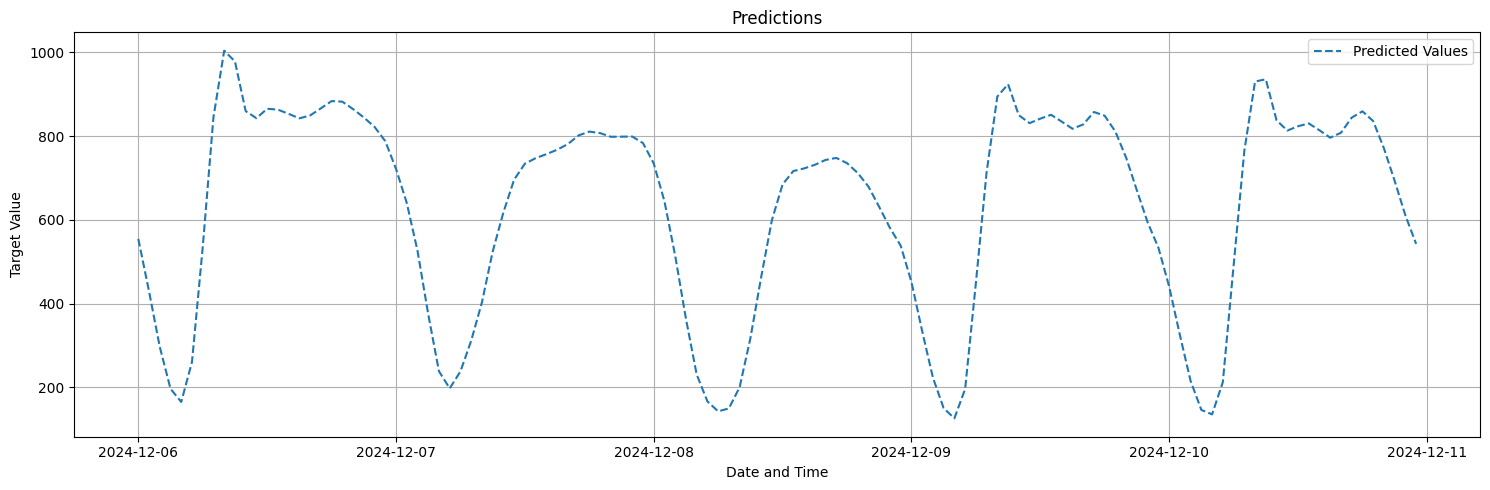

In [231]:
import matplotlib.pyplot as plt

# Plot predictions vs. actual values
plt.figure(figsize=(15, 5))

# Plot predicted values
plt.plot(predictions.index.get_level_values('timestamp'),
         predictions['mean'],
         label='Predicted Values',
         linestyle='--')

# Customize the plot
plt.xlabel('Date and Time')
plt.ylabel('Target Value')
plt.title('Predictions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [232]:
type(predictions)

autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame

In [ ]:
# Ensure the directory exists
output_dir = "predictions"
os.makedirs(output_dir, exist_ok=True)

# Convert the TimeSeriesDataFrame to a pandas DataFrame
predictions_df = predictions.to_data_frame()

# Iterate over each time series in the DataFrame
for street, street_data in predictions_df.groupby(level=0):  # Assumes street info is in the first level of the index
    # Save to a CSV file
    output_file = f"{output_dir}/{street}-{target_variable}.csv"
    street_data.reset_index(level=0, drop=True).to_csv(output_file)

print(f"Predictions saved to {output_dir}/")

Predictions saved to predictions/
